# Calculate Velocities from Kinematic Processing

This notebook calculates velocities from post-processed GNSS data and saves them in the subdirectory 'final_data'.

In [14]:
#import modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Read in your output data from your GNSS post-processing here. You must set the correct filepath to your output file.

In [25]:
#read output from RTK processing and conversion to LV95
filepath = '../proc_data/PPM3/PPM3LV95.csv'
df=pd.read_csv(filepath)
df.set_index('time', inplace=True)
df.index = pd.to_datetime(df.index)
df.head()

,LV95_east,LV95_north,LV95_height,Q,ns,sdn(m),sde(m),sdu(m),sdne(m),sdeu(m),sdun(m),age(s),ratio
time,,,,,,,,,,,,,
2020-07-21 13:47:30.003,2672372.113,1161455.780,2522.460,1,4,0.044,0.012,0.065,0.011,-0.013,-0.052,0.0,4.0
2020-07-21 13:48:00.000,2672371.026,1161456.365,2524.873,2,4,10.147,2.663,5.052,5.197,-3.666,-7.158,0.0,2.1
2020-07-21 13:48:10.000,2672372.063,1161454.504,2523.296,1,4,0.244,0.057,0.147,0.117,-0.090,-0.189,0.0,4.0
2020-07-21 13:48:20.000,2672372.069,1161454.520,2523.282,1,4,0.239,0.054,0.143,0.114,-0.088,-0.184,0.0,3.7
2020-07-21 13:48:30.000,2672372.049,1161460.275,2522.990,2,4,0.278,0.107,0.220,0.133,-0.106,-0.217,0.0,1.8


In [26]:
#removing outlayers

#remove values with large uncertainty in location
df = df[(df['sde(m)']<0.2) & (df['sdn(m)']<0.2) & (df['sdu(m)']<0.5)]

#resample to 10min values
df_res_med = df.resample('10min', label='left').median()
df_res_std = df.resample('10min', label='left').std()
df_res_count = df.resample('10min', label='left').count()
df_res_med.index = df_res_med.index+pd.Timedelta('5min')
df_res_std.index = df_res_std.index+pd.Timedelta('5min')
df_res_count.index = df_res_count.index+pd.Timedelta('5min')

#remove values with large standard deviations and write into new dataframe
idx_rm = (df_res_std['LV95_east']<0.01) & (df_res_std['LV95_north']<0.01) & (df_res_std['LV95_height']<0.01)
df_pos = pd.DataFrame()
df_res_med[~idx_rm] = np.nan
df_pos['E[m]'] = df_res_med['LV95_east']
df_pos['N[m]'] = df_res_med['LV95_north']
df_pos['H[m]'] = df_res_med['LV95_height']
df_pos['sE[m]'] = df_res_std['LV95_east'] #/ np.sqrt(df_res_count['LV95_east'])
df_pos['sN[m]'] = df_res_std['LV95_north'] #/ np.sqrt(df_res_count['LV95_north'])
df_pos['sH[m]'] = df_res_std['LV95_height'] #/ np.sqrt(df_res_count['LV95_height'])

# remove values that show large changes
df_diff_rm = df_pos.copy()
df_diff_rm = df_diff_rm.diff()
idx_rm = (df_diff_rm['E[m]']<1) & (df_diff_rm['N[m]']<1) & (df_diff_rm['H[m]']<1)
df_pos[~idx_rm] = np.nan

# remove leading lines with nan
first_val_idx = df_pos.first_valid_index()
df_pos = df_pos.loc[df_pos.first_valid_index():] #first row without only nan

df_pos.head()

,E[m],N[m],H[m],sE[m],sN[m],sH[m]
time,,,,,,
2020-07-21 14:45:00,2.672372e+06,1.161459e+06,2521.3510,0.003200,0.003757,0.008099
2020-07-21 14:55:00,2.672372e+06,1.161459e+06,2521.3565,0.004993,0.002871,0.006338
2020-07-21 15:05:00,2.672372e+06,1.161459e+06,2521.3645,0.007508,0.003265,0.008012
2020-07-21 15:15:00,2.672372e+06,1.161459e+06,2521.3455,0.004578,0.002268,0.006228
2020-07-21 15:25:00,2.672372e+06,1.161459e+06,2521.3485,0.002827,0.002920,0.006198


In [27]:
#velocity calculation

#rolling mean over displacement
df_roll = df_pos.copy()
df_roll = df_roll.interpolate()
df_roll = df_roll.rolling('6H').mean()
df_roll.index = df_roll.index+pd.Timedelta('3H') #account for 6H rolling mean
df_roll_mean = df_roll.resample('1H').mean()
df_roll_std = df_roll.resample('1H').std()
df_roll_count = df_roll.resample('1H').count()
# uncertainties
df_roll_mean['sE[m]'] = df_roll_std['E[m]'] / np.sqrt(df_roll_count['E[m]'])
df_roll_mean['sN[m]'] = df_roll_std['N[m]'] / np.sqrt(df_roll_count['N[m]'])
df_roll_mean['sH[m]'] = df_roll_std['H[m]'] / np.sqrt(df_roll_count['H[m]'])

df_roll_mean.index = df_roll_mean.index+pd.Timedelta('0.5H') #account for 1H mean

#remove artefacts from rolling
first_val_idx = df_roll_mean.first_valid_index()
df_roll_mean = df_roll_mean.loc[df_roll_mean.first_valid_index():] #first row without only nan
df_roll_mean = df_roll_mean.iloc[6:]

df_diff = df_roll_mean.copy()
df_diff['time'] = df_diff.index
df_diff.index = df_diff.index+pd.Timedelta('0.5H') #account for diff between 1h samples
to_cmperday = 100 * 86400
df_diff['dt'] = df_diff['time'].diff().dt.total_seconds()
df_diff['VE'] = df_diff['E[m]'].diff() * to_cmperday / df_diff['dt']
df_diff['VN'] = df_diff['N[m]'].diff() * to_cmperday / df_diff['dt']
df_diff['VH'] = df_diff['H[m]'].diff() * to_cmperday / df_diff['dt']
df_diff['VHor'] = np.sqrt(df_diff['VE']**2 + df_diff['VN']**2)
df_diff['V3D'] = np.sqrt(df_diff['VE']**2 + df_diff['VN']**2 + df_diff['VH']**2)

#uncertainties
df_diff_shift = df_diff.shift(1) #shift by 1
df_diff['sVE'] = np.sqrt(df_diff['sE[m]']**2 + df_diff_shift['sE[m]']**2) * to_cmperday / df_diff['dt']
df_diff['sVN'] = np.sqrt(df_diff['sN[m]']**2 + df_diff_shift['sN[m]']**2) * to_cmperday / df_diff['dt']
df_diff['sVH'] = np.sqrt(df_diff['sH[m]']**2 + df_diff_shift['sH[m]']**2) * to_cmperday / df_diff['dt']
df_diff['sVHor'] = np.sqrt(df_diff['sVE']**2 + df_diff['sVN']**2) 
df_diff['sV3D[cm/d]'] = np.sqrt(df_diff['sVE']**2 + df_diff['sVN']**2 + df_diff['sVH']**2) 

df_diff.drop(['time'], inplace=True, axis=1)
df_diff.head()

,E[m],N[m],H[m],sE[m],sN[m],sH[m],dt,VE,VN,VH,VHor,V3D,sVE,sVN,sVH,sVHor,sV3D[cm/d]
time,,,,,,,,,,,,,,,,,
2020-07-22 00:00:00,2.672372e+06,1.161459e+06,2521.345566,0.000045,0.000373,0.000149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-22 01:00:00,2.672372e+06,1.161459e+06,2521.342922,0.000054,0.000635,0.000424,3600.0,0.264262,-10.772806,-6.345735,10.776047,12.505660,0.168762,1.767777,1.079575,1.775814,2.078220
2020-07-22 02:00:00,2.672372e+06,1.161459e+06,2521.340249,0.000043,0.000760,0.000358,3600.0,0.824073,-12.497531,-6.414815,12.524671,14.071859,0.165957,2.376547,1.331846,2.382334,2.729346
2020-07-22 03:00:00,2.672372e+06,1.161459e+06,2521.338054,0.000059,0.000602,0.000121,3600.0,0.119260,-13.465310,-5.267407,13.465838,14.459404,0.176192,2.327229,0.905935,2.333889,2.503548
2020-07-22 04:00:00,2.672372e+06,1.161459e+06,2521.336765,0.000174,0.000569,0.000413,3600.0,-2.146667,-12.522594,-3.094074,12.705256,13.076576,0.442201,1.989389,1.032684,2.037943,2.284655


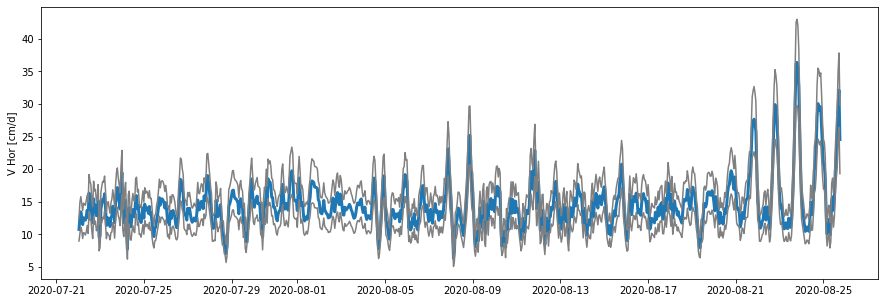

In [28]:
#Velocity Plot Horizontal with Uncertainties for Quality Control
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_diff['VHor'], linewidth=3)
ax.plot(df_diff['VHor']+df_diff['sVHor'], color='gray')
ax.plot(df_diff['VHor']-df_diff['sVHor'], color='gray')
ax.set_ylabel('V Hor [cm/d]')
plt.show()

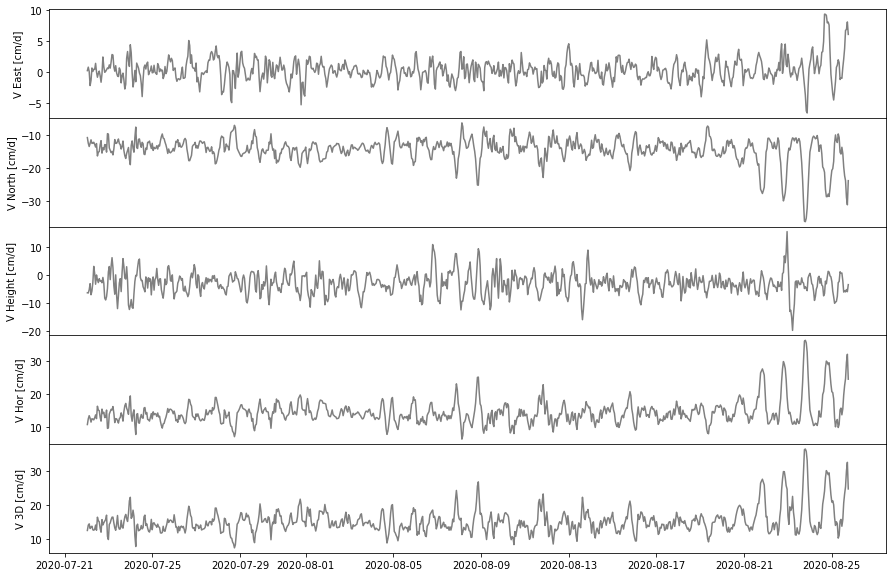

In [29]:
#Velocity Plot for all components for Quality Control
fig, ax = plt.subplots(5, sharex=True, figsize=(15,10))
ax[0].plot(df_diff['VE'],
      color='gray', marker='', linestyle='-')
ax[0].set_ylabel('V East [cm/d]')

ax[1].plot(df_diff['VN'],
      color='gray', marker='', linestyle='-')
ax[1].set_ylabel('V North [cm/d]')

ax[2].plot(df_diff['VH'],
      color='gray', marker='', linestyle='-')
ax[2].set_ylabel('V Height [cm/d]')

ax[3].plot(df_diff['VHor'],
      color='gray', marker='', linestyle='-')
ax[3].set_ylabel('V Hor [cm/d]')

ax[4].plot(df_diff['V3D'],
      color='gray', marker='', linestyle='-')
ax[4].set_ylabel('V 3D [cm/d]')

plt.subplots_adjust(hspace=0)
plt.show()

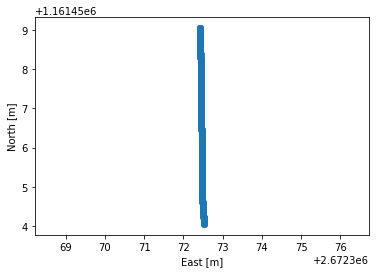

In [30]:
#Plot a map
fig, ax = plt.subplots()
ax.scatter(df_diff['E[m]'].tolist(), 
        df_diff['N[m]'].tolist())
plt.axis('equal')
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.show()

Finally we write the processed data into a file in the subdirectory 'final_data'.

In [31]:
#write dataframe to file
df_write = df_diff.copy()
df_write = df_write.drop('dt', axis=1) #remove time differences

#round for nice formatting in output file
df_write[['E[m]','N[m]','H[m]']] = df_write[['E[m]','N[m]','H[m]']].round(3)
df_write[['sE[m]','sN[m]','sH[m]']] = df_write[['sE[m]','sN[m]','sH[m]']].round(4)
df_write[['VE','VN','VH','VHor','V3D']] = df_write[['VE','VN','VH','VHor','V3D']].round(1)
df_write[['sVE','sVN','sVH','sVHor','sV3D[cm/d]']] = df_write[['sVE','sVN','sVH','sVHor','sV3D[cm/d]']].round(1)

station = os.path.dirname(filepath).split('/')[-1]
out_dir= '../final_data/'+station
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
df_write.to_csv(os.path.join(out_dir, station+'.csv'), date_format='%Y-%m-%dT%H:%M:%SZ')